# Results

The script below runs the model, outputs the results, and generates the following figures:
- [Figures 1 & 2: Non-stationarity impacts](#fig1)
- [Crop coefficient figure](#fig3)
- [Dynamic Stress-Yield Relationships](#yields)
- [LGP impacts on yield](#lgp)

For imports/exports of simulations:
- Start [here](#import) where the 10,000 simulations are imported in to make figures for 180-day variety.
- Start [here](#import2) where the 10,000 simulations for the groups of varieties are made.

Last updated: 20 September 2020

In [2]:
## We need to add the module path to our system path so 
## so that our notebook can find our local objects and code:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
     
# import packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from math import exp
import seaborn as sns
import sys
import glob
from dateutil.relativedelta import *
from numpy.random import exponential, uniform
import scipy.stats as st

# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.functions import *

# set background color
plot.rc['figure.facecolor'] = 'white'
plot.rc.axesfacecolor = 'white'

# Uncomment for black background figure
# plt.rcParams.update({
#     "grid.color": "white",
#     'hatch.color': 'k',
#     "lines.color": "white",
#     "patch.edgecolor": "white",
#     'patch.facecolor': ([0, 1, 1]),
#     'grid.alpha': 0.4,
#     "text.color": "lightgray",
#     "axes.facecolor": "black",
#     "axes.edgecolor": "lightgray",
#     "axes.labelcolor": "white",
#     "xtick.color": "white",
#     "ytick.color": "white",
#     "grid.color": "lightgray",
#     "figure.facecolor": "black",
#     "figure.edgecolor": "black",
#     "savefig.facecolor": "black",
#     "savefig.edgecolor": "black"})

In [3]:
def run(n_sim = 10000, burn_in = 60,  station = 'OL JOGI FARM', data_file = module_path + '/data/CETRAD/CETRAD_rainfall.csv',
    texture = 'clay loam', lgp=180, pd_sim=60, interval='dekad'):
    """ Set up model conditions for model runs. 

    Usage: run(n_sim, burn_in, station, data_file, texture, lgp, pd_sim, interval)
           
    Default values:
        n_sim = 1000 # Number of Simulations to Remove Initial Conditions [integer]
        burn_in = 60 # Number of Days to Run for Initial Conditions Removal [integer]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'clay loam' # Soil Type [string]
        lgp = 180 # Length of Growing Period [days]
        pd_sim 100 # Planting Date for Simulation [day of year]
        data_file = module_path + '/data/CETRAD/CETRAD_rainfall.csv' # Location of Rainfall Data [csv file]
        interval = 'dekad' # Time interval to calculate alpha and lambda parameters [string]

    """
    ## Step 1: Run model
    # Part 1. Set conditions for IC runs
    doy = pd_sim - burn_in
    while doy < 1:
        doy = 365 + doy
    
    print("Step 1: \n\t...Conducting burn in starting at doy {doy}, which is {burn_in} days before the simulated planting date of {pd_sim}.".format(
        doy=doy,
        burn_in=burn_in,
        pd_sim=pd_sim)
    )
    
    # Part 2. Initialize model with a climate, soil and crop
    print("Step 2: \n\t...Initializing {interval} lamba and alphas based on {station} using {data_file}.".format(
        interval=interval,
        station=station,
        data_file=data_file)
    )
    
    s0_climate = Climate(data_file=data_file, station=station, interval=interval)
    
    print("\t...Initializing soil as {texture}".format(texture=texture))
    soil = Soil(texture=texture)
    
    print("\t...Initializing crop with {lgp} days to maturity".format(lgp=lgp))
    crop = Crop(soil=soil, lgp=lgp)
    
    print("\t...Setting nZr parameter to {nZr}".format(nZr=soil.set_nZr(crop)))
    soil.set_nZr(crop)
    
    model = CropModel(crop=crop, climate=s0_climate, soil=soil)
    
    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    n_burn_in_sims = max(10, int(n_sim*.10))
    print("Step 3: \n\t... Setting number of burn in simulations to {n_burn_in_sims}".format(
        n_burn_in_sims=n_burn_in_sims)
    )
    
    print("\t...Computing average soil moisture for doy {doy} using {n_sim} simulations".format(
        doy=doy,
        n_sim=n_burn_in_sims)
    )
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_burn_in_sims, doy=doy)
    print("\t\t[s0_mean]:{s0_mean}\t[s0_std]:{s0_std}".format(
        s0_mean=s0_mean,
        s0_std=s0_std)
    )
    models = [CropModel(
                  crop=crop,
                  climate=Climate(alpha_r=s0_climate.alpha_r, lambda_r=s0_climate.lambda_r),
                  soil=soil) for i in np.arange(n_sim)
               ]
    
    # Part 4. Run the actual simulations 
    print("Step 4: \n\t... Running {n_sim} simulations.".format(n_sim=n_sim))
    # We imported printProgressBar from functions.py earlier:
    printProgressBar(0, n_sim, prefix = 'Progress:', suffix = 'Complete', length = 50)
    output = []
    for i, model in enumerate(models):
        output.append(model.run(s0=s0_mean, do_output=True, t_before=burn_in, planting_date=pd_sim))
        printProgressBar(i + 1, n_sim, prefix = 'Progress:', suffix = 'Complete', length = 50)
    #output = [model.run(s0=s0_mean, do_output=True, t_before=burn_in, planting_date=pd_sim) for model in models]

    print("\t... Done.")

    # Part 5. Subset the growing period and get avg soil moisture
    print("Step 5: \n\t...Subsetting data to growing period.")
 
    start = burn_in 
    end = start + lgp
    avg_s = [df[start:end]['s'].mean() for df in output]
    
    # Part 6. Output the dynamic stress and yield values (just added this 08-17-2020)
    # old: x = [crop.calc_dstress(s=df[start:end].s, stress=df[start:end].stress) for df in output] #for i in np.arange(n_sim)
    print("Step 6: \n\t...Calculating plant stress.")

    x = [crop.calc_dstress(s=df[start:end].s, stress=df[start:end].stress, Y_MAX = evolved_calc_yield(dtm=lgp)) for df in output]
    
    #print(output[0][start:end].s)
    rf = [df[start:end]['R'].sum() for df in output]
    
    return x, rf, int(lgp), avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in

x, rf, lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in = run()

Step 1: 
	...Conducting burn in starting at doy 365, which is 60 days before the simulated planting date of 60.
Step 2: 
	...Initializing dekad lamba and alphas based on OL JOGI FARM using /Users/charrua/Box Sync/waves/maize-Toff/data/CETRAD/CETRAD_rainfall.csv.
	...Initializing soil as clay loam
	...Initializing crop with 180 days to maturity
	...Setting nZr parameter to 190.39999999999998
Step 3: 
	... Setting number of burn in simulations to 1000
	...Computing average soil moisture for doy 365 using 1000 simulations
		[s0_mean]:0.5348048483270926	[s0_std]:0.05086098787359395
Step 4: 
	... Running 10000 simulations.
Progress: |██████████████████████████████████████████████████| 100.0% Complete
	... Done.
Step 5: 
	...Subsetting data to growing period.
Step 6: 
	...Calculating plant stress.


In [4]:
# Check that the start and end is right.
# Should be 180 days time series with the first row, dos=1
output[1][start:end]

,kc,LAI,stress,R,s,E,ET,T,L,dsdt,dos,doy
60,0.300000,0.75,1.000000,0.0,0.524251,0.340431,0.340431,0.000000,0.0,-0.340431,1.0,60
61,0.300000,0.75,1.000000,0.0,0.522463,0.331710,0.331710,0.000000,0.0,-0.331710,2.0,61
62,0.300000,0.75,1.000000,0.0,0.520720,0.323286,0.323286,0.000000,0.0,-0.323286,3.0,62
63,0.300000,0.75,1.000000,0.0,0.519023,0.315146,0.315146,0.000000,0.0,-0.315146,4.0,63
64,0.300000,0.75,1.000000,0.0,0.517367,0.307278,0.307278,0.000000,0.0,-0.307278,5.0,64
...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.655556,3.00,0.780544,0.0,0.559129,0.170395,0.729673,0.559278,0.0,-0.729673,176.0,235
236,0.641667,3.00,0.807865,0.0,0.555297,0.163403,0.649101,0.485697,0.0,-0.649101,177.0,236
237,0.627778,3.00,0.832564,0.0,0.551888,0.157266,0.577508,0.420242,0.0,-0.577508,178.0,237
238,0.613889,3.00,0.854852,0.0,0.548854,0.151872,0.513878,0.362006,0.0,-0.513878,179.0,238


### Test out the code with this figure to see if it makes what we want: 

ValueError: operands could not be broadcast together with shapes (180,) (121,) 

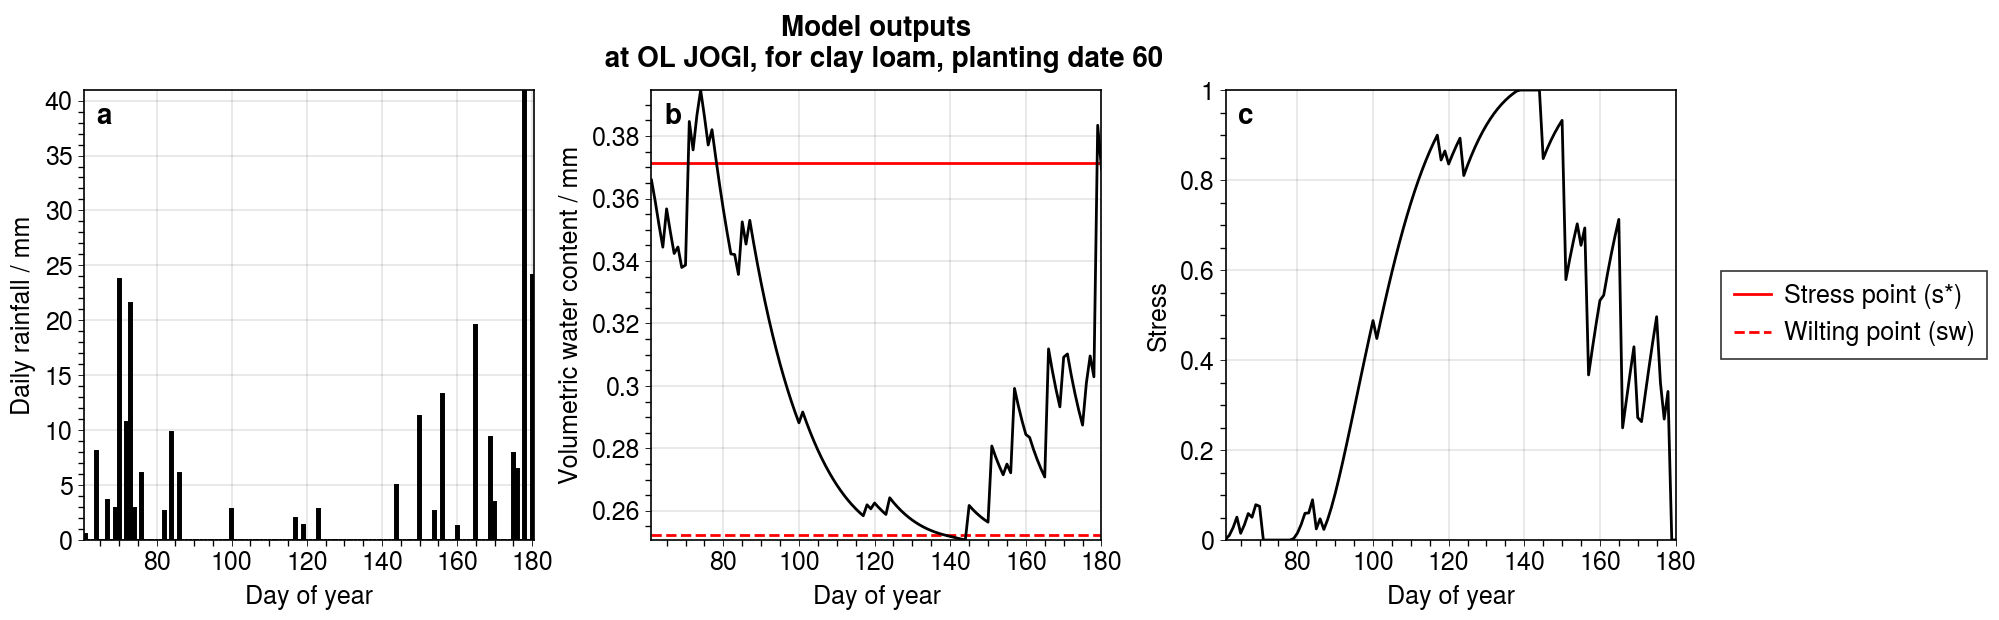

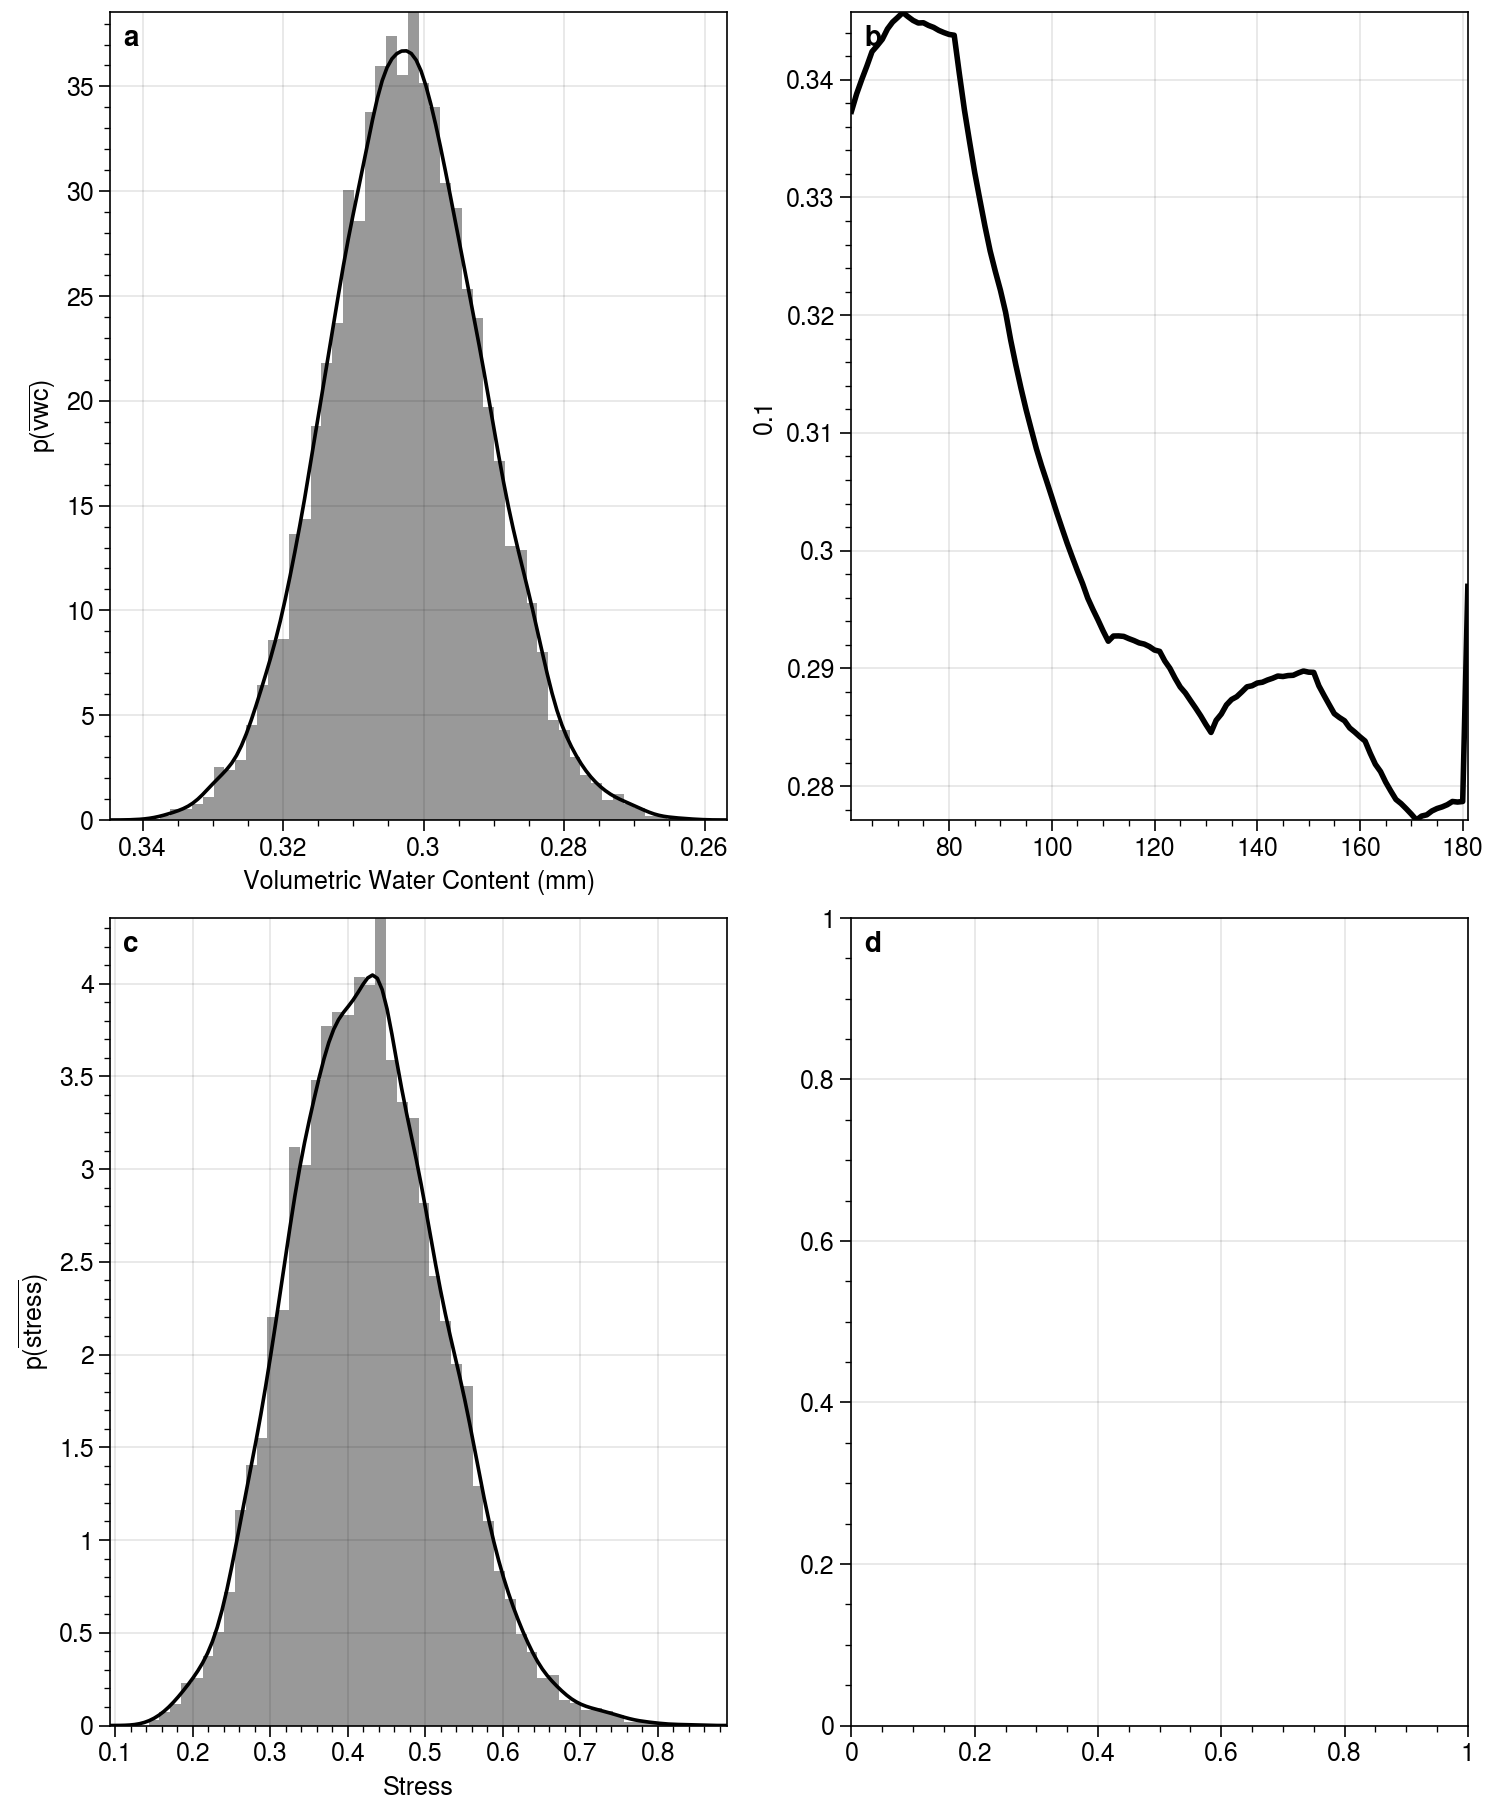

In [25]:
def figure1(lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in):
    """ Generates a PDF of seasonal soil moisture for a specific climate, soil, and crop.

    Usage: figure1(lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in)
        Takes all the outputs from the previous function and generates time series figure

    """
    # Step 2: Make figures
    # Part 6. Decide whether using white (publication) or black background (presentation): 
    # for white background
    col='k'
    
    # for black backgroumd
    #col='white'
    
    # If using the raw output need to have theses start and end vals:
    start = 60
    end = 240
    
    # If using reimported outputs, we can set start and end to 0 and 180:
    #start = 0 
    #end = 180
    #burn_in = 1
    
    f, axs = plot.subplots(nrows = 1, ncols = 3, share=0) # journal='agu1', tight=False
    axs.format(
        abc=True, abcloc='ul', suptitle='Model outputs \n at %s' %station + ', for %s' %texture + ', planting date %s' %pd_sim
    )
    axs.tick_params('both', length=2, width=0.3, which='major', colors=col)

    # TOP FIGURE
    # Do some shenanigans to select a simulation that dips below wilting point
    s_min = []
    no_sims = np.arange(0,n_sim)
    
    for i in no_sims:
        #print(output[i][start:end]['s'].min())
        _s_min = output[i][start:end]['s'].min()
        s_min.append(_s_min)
    result = pd.DataFrame({'s_min':s_min, 'no':no_sims})

    # which simulation has the smallest s value?
    lowest = result[['s_min']].idxmin().item() #result[126:] yup, looks good
    #print(lowest)
    lowest=162
    # Figure 1a: Rainfall from one simulation
    rf = output[lowest][start:end]['R']
    stress = output[lowest][start:end]['stress']
    
    # Adjust index to account for the fact that python is zero-indexed
    rf.index = rf.index+1 # change index so that we can see day of season
    stress.index = stress.index+1
    
    axs[0,0].bar(rf, color=col, edgecolor=col) #darkblue, ,
    axs[0,0].format(ylabel='Daily rainfall / mm')
    #axs[0,0].format(xlabel='Day of season')
    axs[0,0].format(xlabel='Day of year')
    #axs[0,0].format(xlim=(60, 240))
    # Figure 1c: stress from one simulation
    axs[0,2].plot(stress, color=col, lw=1) #color='lightblue',lw=1, 
    axs[0,2].format(ylabel='Stress')
    #axs[0,2].format(xlim=(60, 240)) # xlim=(0, 0.4), 
    #axs[0,2].format(xlabel='Day of season')
    axs[0,2].format(xlabel='Day of year')
        
    # Figure 1b: Soil moisture from one simulation
    # convert saturation to volumetric water content:
    # relative saturation*porosity
    # we have the function theta already but I'm not sure that we call on that.
    vwc = output[lowest][start:end]['s']*Soil(texture).n
    
    _sstar = crop.s_star*Soil(texture).n # convert s_star and sw
    _sw = crop.sw*Soil(texture).n
    
    # LEGEND
    hs = []
    cycle = ['-','--']
    var = [_sstar, _sw]
    LABEL = ['Stress point (s*)','Wilting point (sw)']
    
    for item, cycle, LABEL in zip(var, cycle, LABEL):
        h = axs[0,1].axhline(y=item, lw=1, color='r', linestyle=cycle, label=LABEL)
        hs.append(h)
    
    f.legend(hs, loc='right', ncols=1, frame=True)
    
    # Adjust index to account for the fact that python is zero-indexed
    vwc.index = vwc.index+1 # need the time series to start at day 1 not day 61
    
    axs[0,1].plot(vwc, color=col, lw=1) #color='lightblue',lw=1, 
    axs[0,1].format(ylabel='Volumetric water content / mm')
    #axs[0,1].format(xlabel='Day of season')
    axs[0,1].format(xlabel='Day of year')
    #axs[0,1].format(xlim=(60, 240))
    #plt.savefig('../output/6-results/fig1.png',format='png')
    
    # Figure 2
    f, axs = plot.subplots(nrows=2, ncols=2, share=0, journal='agu4')
    axs.format(abc=True, abcloc='ul') # suptitle='Figure 2'
    
    # Figure a: Soil moisture distribution - converted
    ax = axs[0,0]
    avg_s = np.array(avg_s)*Soil(texture).n
    sns.distplot(avg_s, ax=ax, color=col, **{'kde': True, 'hist': True}) # hist_kws={"color": 'gainsboro'}
    #ax.format(xlim=(0.2, 0.5), ylim=(0, 15))
    ax.format(ylabel=r'p($\overline{vwc}$)')
    ax.format(xlabel='Volumetric Water Content (mm)')
    
    # Figure c: Stress distribution
    ax = axs[1,0]
    avg_stress = [df[start:end]['stress'].mean() for df in output]
    sns.distplot(avg_stress, ax=ax, color=col,**{'kde': True, 'hist': True}) # hist_kws={"color": 'black'
     
    #ax.format(xlim=(-0.1, 0.9), ylim=(0, 10))
    ax.format(ylabel=r'p($\overline{stress}$)')
    ax.format(xlabel='Stress')
    
    # Figure b: Soil moisture time series - need to convert this one
    avg_daily = pd.concat([df[start:end]['s'] for df in output], axis=1); avg_daily
    avg_daily = avg_daily*Soil(texture).n; avg_daily
    avg_daily_t = avg_daily.T; avg_daily_t
    daily_mean = avg_daily.mean(axis=1); daily_mean
    daily_mean.index = daily_mean.index+1 # Change index so that we can see day of season
    daily_mean
    #data = np.array(daily_mean)
    axs[0,1].plot(daily_mean, color=col, lw=2)

    #x = np.arange(1, len(daily_mean)+1, 1)
    # use this for raw output
    x = np.arange(60, 240, 1)

    # set custom x axis
    #axs[0,1].format(xlim=(60, 240)) #, ylim=(0, 10))
    
    quant = avg_daily_t.quantile([.1, .9])
    quant = quant.T
    axs[0,1].fill_between(x, quant[0.1], quant[0.9]) # ,facecolor='gainsboro'
    axs[0,1].format(ylim=(0.2, 0.5)) #xlim=(0.3, 0.8), 
    #axs[0,1].format(xlabel='Day of season')
    axs[0,1].format(xlabel='Day of year')
    axs[0,1].format(ylabel='Volumetric Water Content / mm')
    
    # Figure f: stress time series
    stress = pd.concat([df[start:end]['stress'] for df in output], axis=1)
    stress_t = stress.T
    daily_mean = stress.mean(axis=1)
    daily_mean.index = daily_mean.index + 1 
    axs[1,1].plot(daily_mean, color=col, lw=2)

    #x = np.arange(1, len(daily_mean)+1, 1) 
    quant = stress_t.quantile([.1, .9])
    quant = quant.T
    axs[1,1].fill_between(x, quant[0.1], quant[0.9]) #,facecolor='dimgray'
    axs[1,1].format(ylim=(-0.05, 1))
    plt.ylabel('Stress')
    axs[1,1].format(ylabel='Stress')
    #axs[1,1].format(xlabel='Day of season')
    axs[1,1].format(xlabel='Day of year')
    ax.xaxis.label.set_color(col)
    axs.tick_params('both', length=2, width=0.3, which='major', colors=col)
    #axs.format(
    # set custom x axis
    #axs[1,1].format(xlim=(60, 240)) #
    #rowlabels=['Volumetric Water Content', 'Stress'],
    collabels=['PDF', 'Time Series']
    
    #plt.savefig('../output/6-results/fig2.png',format='png')
    print('s star',_sstar,'sw',_sw)

figure1(lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in)

In [6]:
# To figure out a better time series to plot, use the following:

# return list of some of lowest time series
s_min = []
no_sims = np.arange(0,n_sim)

for i in no_sims:
    #print(output[i][start:end]['s'].min())
    _s_min = output[i][start:end]['s'].min()
    s_min.append(_s_min)
result = pd.DataFrame({'s_min':s_min, 'no':no_sims})

# which simulation has the smallest s value?
lowest = result[['s_min']].idxmin().item() #result[126:] yup, looks good
print(lowest)

result.s_min.sort_values().head(50)

4810


4810    0.447439
235     0.451680
3185    0.451785
4841    0.451785
7147    0.452611
5842    0.452848
5816    0.453685
754     0.453766
73      0.454019
384     0.454019
3125    0.454019
9488    0.454019
5346    0.454019
2814    0.454019
2877    0.454187
4355    0.454274
8224    0.454357
5188    0.454357
4778    0.454357
7174    0.454459
162     0.454671
7539    0.454700
4577    0.454750
9557    0.454937
9063    0.455049
8494    0.455049
9326    0.455049
5288    0.455049
8478    0.455049
663     0.455069
7795    0.455303
8954    0.455403
8734    0.455403
8846    0.455403
9591    0.455404
5327    0.455546
1618    0.455598
5171    0.455762
2533    0.455778
5338    0.455838
3108    0.456014
2119    0.456079
5425    0.456127
6003    0.456127
7602    0.456127
4380    0.456127
1660    0.456214
2667    0.456219
2921    0.456224
2468    0.456370
Name: s_min, dtype: float64

## Parameters

Using the following parameters, generate 10,000 simulations.

TODO. Need to figure out how to extract each variable from this dictionary.

In [7]:
output_vars = {'n_sim': 10000, 'burn_in': 60, 'station': 'OL JOGI', 'texture': 'clay loam', 'lgp':180, 'pd_sim':60}
output_vars.keys()
for i in output_vars.keys():
    i = output_vars.items()

n_sim = 10000
no_sims = np.arange(0,n_sim)

burn_in = 60
station = 'OL JOGI'
texture = 'clay loam'
lgp=180
pd_sim=60

start = burn_in 
end = start + lgp

## Export 10,000 simulations

In [8]:
# export simulations
for i in no_sims:
    output[i][start:end].to_csv('../output/final/%s.csv' % i)


## Reimport 10,000 simulations <a id='import'></a>

In [12]:
n_sim = 10000
no_sims = np.arange(0,n_sim)

# this takes a while
files = glob.glob('../output/final/*.csv')
output = []
for f, n in zip(files, no_sims):
    f_ = pd.read_csv(f).drop('Unnamed: 0',axis=1)
    output.append(f_)

output[99]

,kc,LAI,stress,R,s,E,ET,T,L,dsdt,dos,doy
0,0.300000,0.75,0.943067,0.0,0.537221,0.405900,0.440560,0.034661,0.0,-0.440560,1.0,60
1,0.300000,0.75,0.961129,0.0,0.534907,0.393941,0.417495,0.023554,0.0,-0.417495,2.0,61
2,0.300000,0.75,0.978403,0.0,0.532714,0.382719,0.395748,0.013029,0.0,-0.395748,3.0,62
3,0.300000,0.75,0.994920,0.0,0.530636,0.372182,0.375234,0.003052,0.0,-0.375234,4.0,63
4,0.300000,0.75,1.000000,0.0,0.528665,0.362281,0.362281,0.000000,0.0,-0.362281,5.0,64
...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.655556,3.00,0.794305,0.0,0.557191,0.166846,0.688905,0.522059,0.0,-0.688905,176.0,235
176,0.641667,3.00,0.820312,0.0,0.553572,0.160289,0.612879,0.452589,0.0,-0.612879,177.0,236
177,0.627778,3.00,0.843801,0.0,0.550353,0.154530,0.545317,0.390786,0.0,-0.545317,178.0,237
178,0.613889,3.00,0.864979,0.0,0.547489,0.149465,0.485262,0.335797,0.0,-0.485262,179.0,238


In [13]:
# Will also need this to make the figures

avg_s = [df[start:end]['s'].mean() for df in output]
soil = Soil(texture=texture)
crop = Crop(soil=soil, lgp=lgp)

## Using the imported time series, make the figures:

### Figures 1 and 2: Time series and PDFs <a id='fig1'></a>

Note for the rainfall time series below, when we do more than 1000+ simulations, we pull out abnormal years where there can be 100 mm in a day. So when we run the final 10,000 time series, just take care to pick a good looking plot for the paper.

s star 0.37128 sw 0.25228


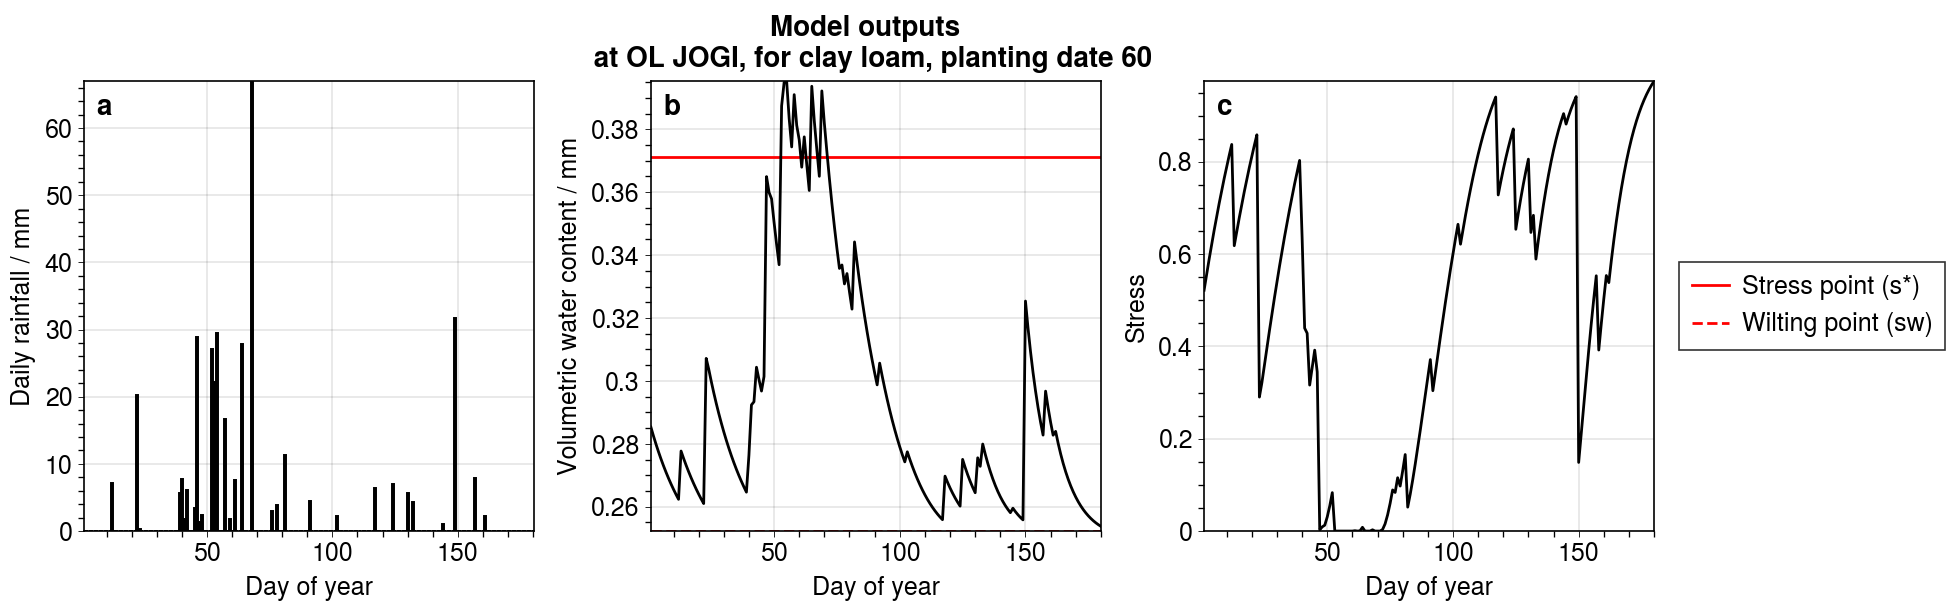

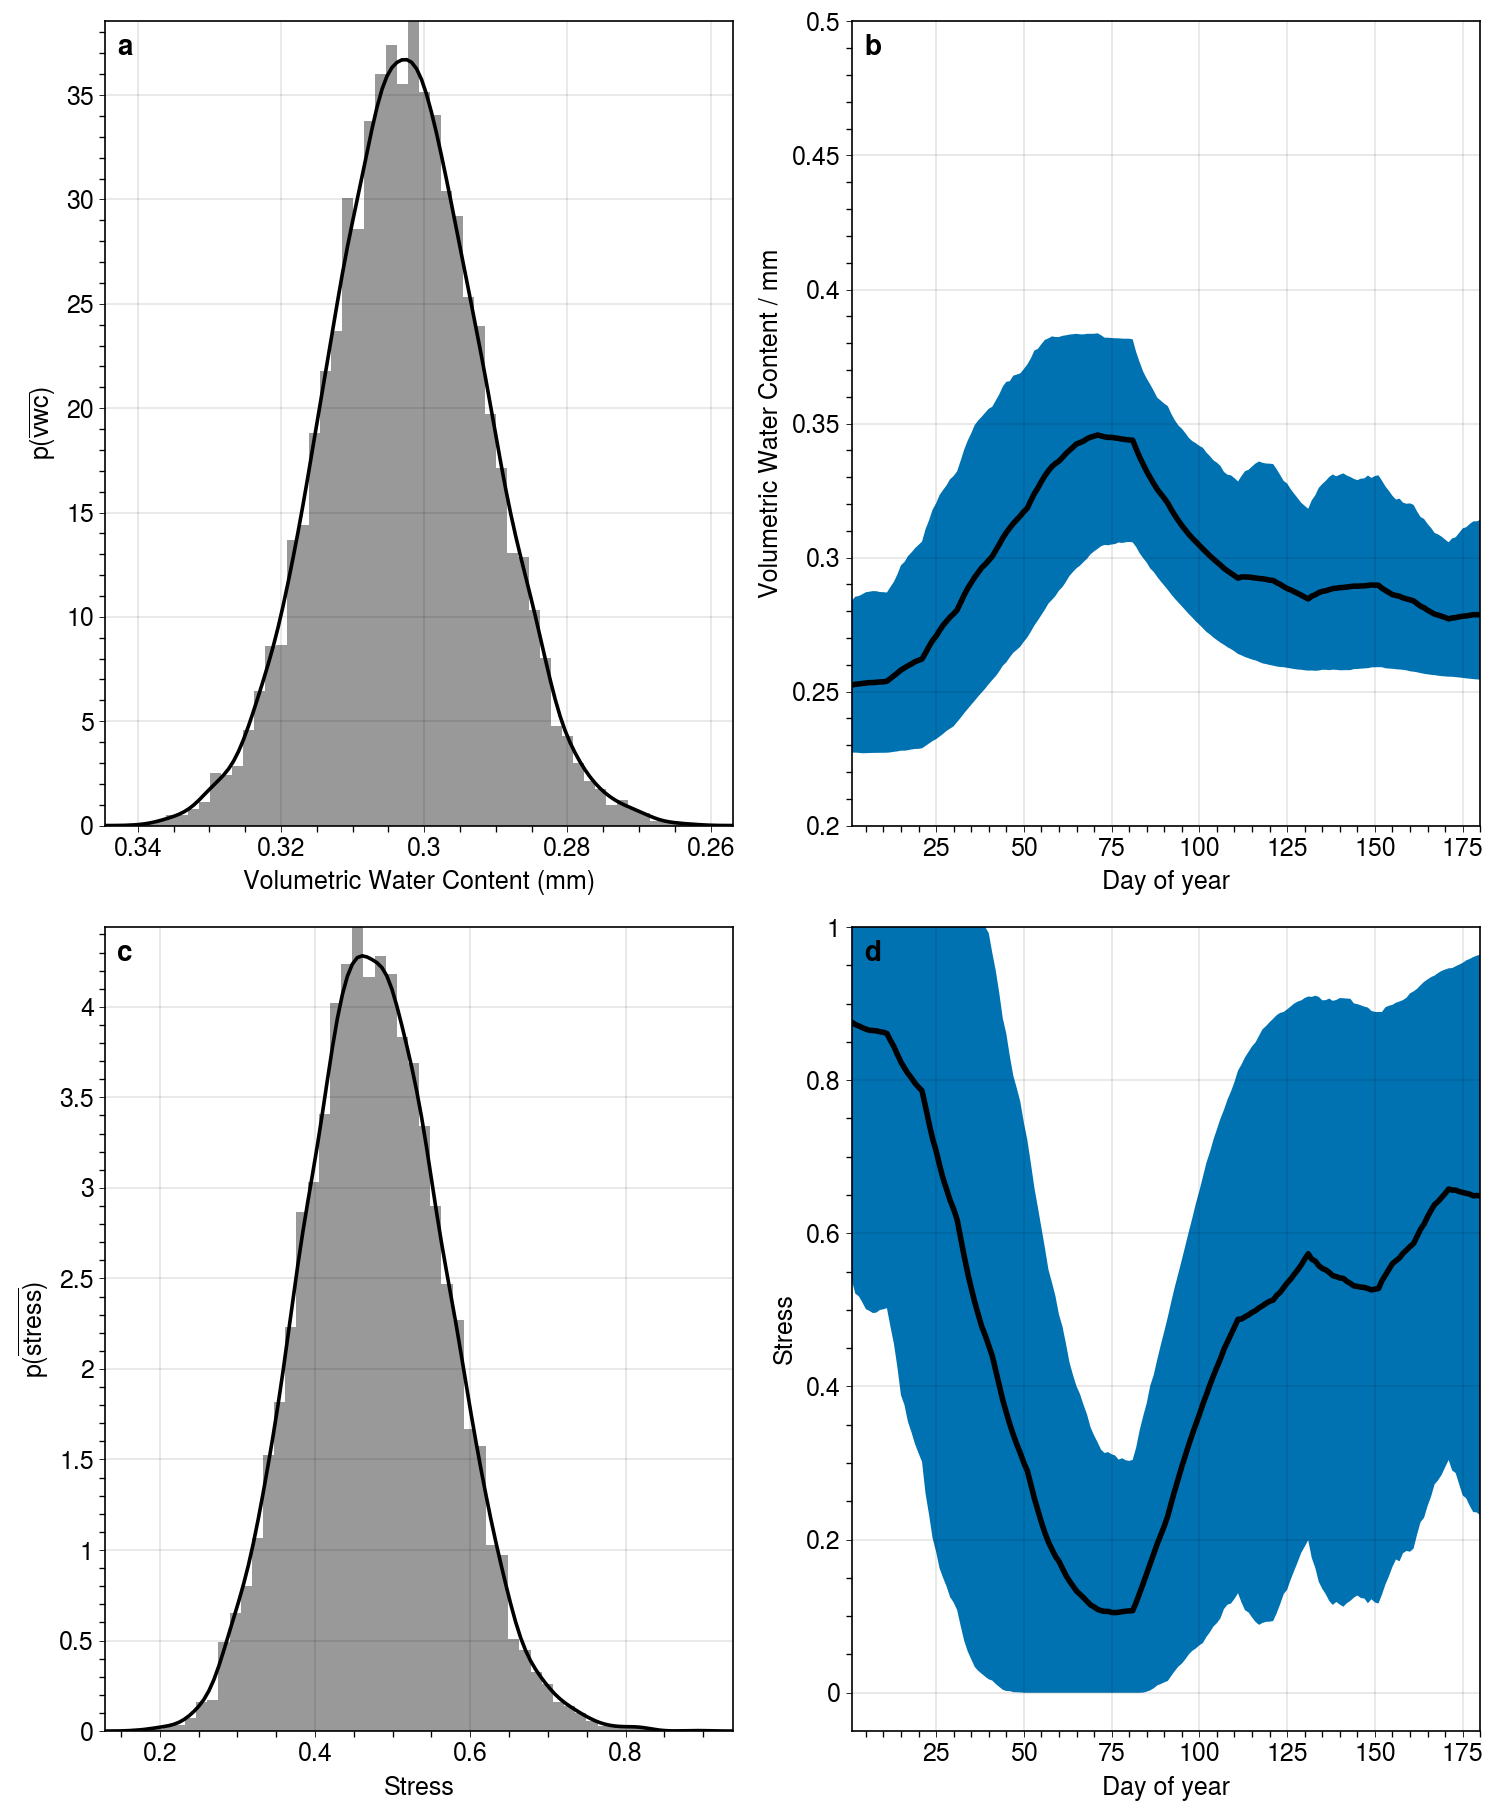

In [17]:
def figure1(lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in):
    """ Generates a PDF of seasonal soil moisture for a specific climate, soil, and crop.

    Usage: figure1(lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in)
        Takes all the outputs from the previous function and generates time series figure

    """
    # Step 2: Make figures
    # Part 6. Decide whether using white (publication) or black background (presentation): 
    # for white background
    col='k'
    
    # for black backgroumd
    #col='white'
    
    # Since we're using the reimported outputs, we can set start and end to 0 and 180
    start = 0 
    end = 180
    #burn_in = 1
    # If we were using the raw output we'd need to have the previous start and end values
    
    f, axs = plot.subplots(nrows = 1, ncols = 3, share=0) # journal='agu1', tight=False
    axs.format(
        abc=True, abcloc='ul', suptitle='Model outputs \n at %s' %station + ', for %s' %texture + ', planting date %s' %pd_sim
    )
    axs.tick_params('both', length=2, width=0.3, which='major', colors=col)

    # TOP FIGURE
    # Do some shenanigans to select a simulation that dips below wilting point
    s_min = []
    no_sims = np.arange(0,n_sim)
    
    for i in no_sims:
        #print(output[i][start:end]['s'].min())
        _s_min = output[i][start:end]['s'].min()
        s_min.append(_s_min)
    result = pd.DataFrame({'s_min':s_min, 'no':no_sims})

    # which simulation has the smallest s value?
    lowest = result[['s_min']].idxmin().item() #result[126:] yup, looks good
    #print(lowest)
    lowest=745
    # Figure 1a: Rainfall from one simulation
    rf = output[lowest][start:end]['R']
    stress = output[lowest][start:end]['stress']
    
    # Adjust index to account for the fact that python is zero-indexed
    rf.index = rf.index+1 # change index so that we can see day of season
    stress.index = stress.index+1
    
    axs[0,0].bar(rf, color=col, edgecolor=col) #darkblue, ,
    axs[0,0].format(ylabel='Daily rainfall / mm')
    #axs[0,0].format(xlabel='Day of season')
    axs[0,0].format(xlabel='Day of year')
    #axs[0,0].format(xlim=(60, 240))
    # Figure 1c: stress from one simulation
    axs[0,2].plot(stress, color=col, lw=1) #color='lightblue',lw=1, 
    axs[0,2].format(ylabel='Stress')
    #axs[0,2].format(xlim=(60, 240)) # xlim=(0, 0.4), 
    #axs[0,2].format(xlabel='Day of season')
    axs[0,2].format(xlabel='Day of year')
        
    # Figure 1b: Soil moisture from one simulation
    # convert saturation to volumetric water content:
    # relative saturation*porosity
    # we have the function theta already but I'm not sure that we call on that.
    vwc = output[lowest][start:end]['s']*Soil(texture).n
    
    _sstar = crop.s_star*Soil(texture).n # convert s_star and sw
    _sw = crop.sw*Soil(texture).n
    
    # LEGEND
    hs = []
    cycle = ['-','--']
    var = [_sstar, _sw]
    LABEL = ['Stress point (s*)','Wilting point (sw)']
    
    for item, cycle, LABEL in zip(var, cycle, LABEL):
        h = axs[0,1].axhline(y=item, lw=1, color='r', linestyle=cycle, label=LABEL)
        hs.append(h)
    
    f.legend(hs, loc='right', ncols=1, frame=True)
    
    # Adjust index to account for the fact that python is zero-indexed
    vwc.index = vwc.index+1 # need the time series to start at day 1 not day 61
    
    axs[0,1].plot(vwc, color=col, lw=1) #color='lightblue',lw=1, 
    axs[0,1].format(ylabel='Volumetric water content / mm')
    #axs[0,1].format(xlabel='Day of season')
    axs[0,1].format(xlabel='Day of year')
    #axs[0,1].format(xlim=(60, 240))
    #plt.savefig('../output/6-results/fig1.png',format='png')
    
    # Figure 2
    f, axs = plot.subplots(nrows=2, ncols=2, share=0, journal='agu4')
    axs.format(abc=True, abcloc='ul') # suptitle='Figure 2'
    
    # Figure a: Soil moisture distribution - converted
    ax = axs[0,0]
    avg_s = np.array(avg_s)*Soil(texture).n
    sns.distplot(avg_s, ax=ax, color=col, **{'kde': True, 'hist': True}) # hist_kws={"color": 'gainsboro'}
    #ax.format(xlim=(0.2, 0.5), ylim=(0, 15))
    ax.format(ylabel=r'p($\overline{vwc}$)')
    ax.format(xlabel='Volumetric Water Content (mm)')
    
    # Figure c: Stress distribution
    ax = axs[1,0]
    avg_stress = [df[start:end]['stress'].mean() for df in output]
    sns.distplot(avg_stress, ax=ax, color=col,**{'kde': True, 'hist': True}) # hist_kws={"color": 'black'
     
    #ax.format(xlim=(-0.1, 0.9), ylim=(0, 10))
    ax.format(ylabel=r'p($\overline{stress}$)')
    ax.format(xlabel='Stress')
    
    # Figure b: Soil moisture time series - need to convert this one
    avg_daily = pd.concat([df[start:end]['s'] for df in output], axis=1); avg_daily
    avg_daily = avg_daily*Soil(texture).n; avg_daily
    avg_daily_t = avg_daily.T; avg_daily_t
    daily_mean = avg_daily.mean(axis=1); daily_mean
    daily_mean.index = daily_mean.index+1 # Change index so that we can see day of season
    daily_mean
    #data = np.array(daily_mean)
    axs[0,1].plot(daily_mean, color=col, lw=2)

    # Use this for imported vals
    x = np.arange(1, len(daily_mean)+1, 1)
    # use this for raw output
    #x = np.arange(60, 240, 1)

    # set custom x axis
    #axs[0,1].format(xlim=(60, 240)) #, ylim=(0, 10))
    
    quant = avg_daily_t.quantile([.1, .9])
    quant = quant.T
    axs[0,1].fill_between(x, quant[0.1], quant[0.9]) # ,facecolor='gainsboro'
    axs[0,1].format(ylim=(0.2, 0.5)) #xlim=(0.3, 0.8), 
    #axs[0,1].format(xlabel='Day of season')
    axs[0,1].format(xlabel='Day of year')
    axs[0,1].format(ylabel='Volumetric Water Content / mm')
    
    # Figure f: stress time series
    stress = pd.concat([df[start:end]['stress'] for df in output], axis=1)
    stress_t = stress.T
    daily_mean = stress.mean(axis=1)
    daily_mean.index = daily_mean.index + 1 
    axs[1,1].plot(daily_mean, color=col, lw=2)

    #x = np.arange(1, len(daily_mean)+1, 1) 
    quant = stress_t.quantile([.1, .9])
    quant = quant.T
    axs[1,1].fill_between(x, quant[0.1], quant[0.9]) #,facecolor='dimgray'
    axs[1,1].format(ylim=(-0.05, 1))
    plt.ylabel('Stress')
    axs[1,1].format(ylabel='Stress')
    #axs[1,1].format(xlabel='Day of season')
    axs[1,1].format(xlabel='Day of year')
    ax.xaxis.label.set_color(col)
    axs.tick_params('both', length=2, width=0.3, which='major', colors=col)
    #axs.format(
    # set custom x axis
    #axs[1,1].format(xlim=(60, 240)) #
    #rowlabels=['Volumetric Water Content', 'Stress'],
    collabels=['PDF', 'Time Series']
    
    #plt.savefig('../output/6-results/fig2.png',format='png')
    print('s star',_sstar,'sw',_sw)

figure1(lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in)

### Figure 3: Three figures including crop coefficient <a id='fig3'></a>

In [18]:
def check_exponential(data):

    """ Defines function that fits daily rainfall amounts to an exponential distribution and returns pdf 
        and r2. The r2 should be above 0.9 to be an exponential.

        Usage:

            check_exponential(data):

                returns r2, pdf

        How it works:
        - Step 1: To fit the distribution, we use functions from python's suite of numerical analysis, scipy.
        The scipy.stats module has a large suite of distribution functions pre-defined, which we can use to 
        develop a fit for our data. The distribution we are interested in is the exponential distribution, 
        which is called expon in the stats module.

        - Step 2-4: Calculate fitted PDF and error with fit in distribution. To test the fit of our distribution, 
        we can compare the empirical histogram to that predicted by our model. We first use our `data` to generate 
        the empirical histogram. In this example, we break the data into `30` bins, and we generate a histrogram 
        of `density` rather than counts. This allows for an easier comparison between our empirical data and the 
        fitted probability distribution function. 
        
        Here are the steps:

        1. Generate a histogram, from the `data`. Save the bin locations in `x` and the density of values in `y`
        2. Shift the `x` bin locations generated from the histogram to the center of bins.
        3. Calculate the value of the fitted `pdf(x)` for each of the bins in `x`.
        4. Determine the residual sum of the squares, $SS_{error}$, and total sum of squares, $SS_{yy}$, according 
        to the equations in rainfall-variability.ipynb.
    """

    # Step 1. Fit the distribution.
    distribution = st.expon
    params = distribution.fit(data, loc=0) # Force the distribution to be built off of zero

    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    y, x = np.histogram(data, bins=30, density=True)

    # Step 2. Shift the x bin locations to the center of bins.
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Step 3. Calculate the values of pdx(x) for all x.
    pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)

    # Step 4. Determine the residual and total sum of the squares.
    ss_error = np.sum(np.power(y - pdf, 2.0))
    ss_yy = np.sum(np.power(y - y.mean(), 2.0))

    r_2 = 1 - ( ss_error / ss_yy )

    if r_2 < 0.9:
        print("WARNING. r2 for {station} is {r_2}".format(
            station=station,
            r_2=r_2))

    return r_2, pdf


def make_climate_parameters(
        station='OL JOGI FARM',
        data_file = module_path + '/data/CETRAD/CETRAD_rainfall.csv',
        year_min=30,
        interval='dekad'):

    """ Defines function that takes a rainfall station time series and returns alpha and lambda values by 
    a certain interval between week (7-days), dekad (10-days), semi-monthly (twice per month) or monthly.

        Usage:

            make_climate_parameters(
                station='OL JOGI FARM', 
                data_file="data/CETRAD/CETRAD_rainfall.csv",
                year_min= 30,
                interval='dekad' 
            )

        Default values:
            station = 'OL JOGI FARM' [string] # Rainfall Climatology for Laikipia 
            data_file = "data/CETRAD/CETRAD_rainfall.csv" # Path to file
            year_min = 30 # Minimum number of years required in timeseries
            interval = 'dekad' # Interval to calculate alphas andlambdas

                returns alpha_values, lambda_values
    """
    # Prepare the CETRAD dataset.
    year_min = year_min # minimum number of years to consider for a valid climate record.

    df = pd.read_csv(data_file)  # Read in the raw csv data.

    # Step 1. Convert text strings into datetime objects.
    format = '%m/%d/%y' # Column RDate has data in M/D/YY
    df['Datetime']=pd.to_datetime(df['RDate'], format=format) # Create a new column of datetime objects using RDate.

    # 2. Step 2. Convert future dates inferred during the conversion back into 20th century dates.
    # Python is a future-looking programming language, and assumes that 1/1/34 is Jan 1, 2034.
    # We can fix this by finding all the dates in the future (dt > datetime.now()) and removing 100 years from
    # their value. This requires using the relativedelta function, which handles weird stuff like leap years.
    df['Datetime'] = df['Datetime'].map(lambda dt: dt+relativedelta(years=-100) if dt > datetime.now() else dt)

    # Step 3. Extract the Year and Month from the Datetime to make aggregation easier.
    df['Year'] = [dt.year for dt in df['Datetime']]
    df['Month'] = [dt.month for dt in df['Datetime']]
    df['Week'] = [dt.week for dt in df['Datetime']]
    df['Semi_Month'] = (df['Datetime'].dt.day
                          .gt((df['Datetime']+pd.tseries.offsets.MonthEnd()).dt.day//2) 
                          + df['Month']*2 -1)
    df['Dekad'] = df['Datetime'].dt.dayofyear//10+1
    
    n_years = len(df['Year'].unique())

    # Check to make sure we have enough data for fitting and parameter estimation.
    if n_years < year_min:
        print("WARNING! Station record for {station} has only {n_years} years.".format(
            station=station,
            n_years=n_years))

    # Step 4. Use the Datetime values as the index for this dataframe.
    df = df.set_index(pd.DatetimeIndex(df['Datetime']))  # Set the Datetime column as the dataframe index

    # Step 5.  Delete the old RDate column, which we no longer need. 
    # We will keep the Datetime column, in case we need it later.
    df = df.drop(['RDate'], axis=1)

    columns = [station] + ['Year', 'Month', 'Week', 'Dekad', 'Semi_Month','Datetime']
    rainfall = df[columns]

    # First, find all the rows in the data where it rained and group by month.
    rain_days = rainfall.loc[rainfall[station] > 0]

    # Find all locations in the data where an observation was made.
    all_days = rainfall.loc[rainfall[station] >= 0]

    # Find just the rainfall amounts on days that it rained.
    data = rainfall.loc[rainfall[station] > 0][station]
    
    # Fit the daily rainfall amounts to an exponential distribution.
    check_exponential(data)

    if interval == 'month':
        # Determine the Monthly values of alpha and lambda from the station data:
        lambda_values = (
            rain_days.groupby('Month')[station].count() /
            all_days.groupby('Month')[station].count()
        )
        alpha_values = rain_days.groupby('Month')[station].mean()
    elif interval == 'dekad':
        lambda_values = (
            rain_days.groupby('Dekad')[station].count() / 
            all_days.groupby('Dekad')[station].count()
        )
        alpha_values = rain_days.groupby('Dekad')[station].mean()
    elif interval == 'semi_month':
        lambda_values = (
            rain_days.groupby('Semi_Month')[station].count() / 
            all_days.groupby('Semi_Month')[station].count()
        )
    else:
        raise(NotImplementedError)

    return alpha_values.to_list(), lambda_values.to_list()


In [19]:
a, l = make_climate_parameters(interval='dekad') # semi_month 

alpha_monthly, lambda_monthly = make_climate_parameters()
# make a dataframe
df = pd.DataFrame({'alpha':a, 'lambda':l, 'dekad':np.arange(1,38,1),'month_A':['10','20','30','40',
                                                                           '50','60','70','80','90','100',
                                                                            '110','120','130','140','150','160',
                                                                               '170','180','190','200','210','220',
                                                                               '230','240','250','260','270','280','290',
                                                                               '300','310','320','330','340','350','360','365'
                                                                              ]})
len(a)

37

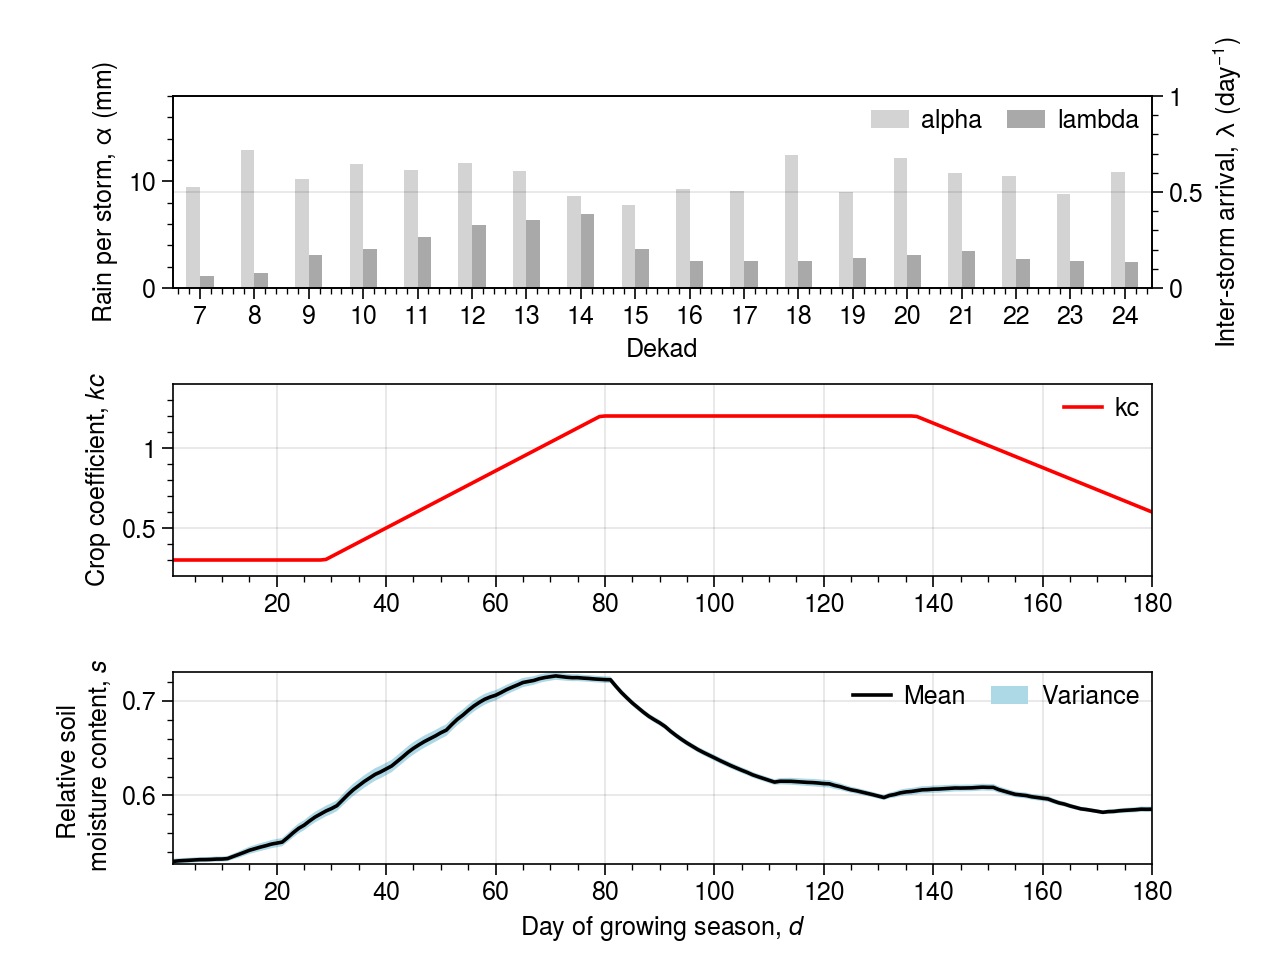

In [20]:
# figure set up
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3,ncols=1, sharex=False)
#fig, axs = plot.subplots(nrows=3, ncols=1, sharex=False)
left   =  0.135  # the left side of the subplots of the figure
right  =  0.9    # the right side of the subplots of the figure
bottom =  0.1    # the bottom of the subplots of the figure
top    =  0.9    # the top of the subplots of the figure
wspace =  .3     # the amount of width reserved for blank space between subplots
hspace =  0.5    # the amount of height reserved for white space between subplots

# This function actually adjusts the sub plots using the above paramters
plt.subplots_adjust(
    left    =  left, 
    bottom  =  bottom, 
    right   =  right, 
    top     =  top, 
    wspace  =  wspace, 
    hspace  =  hspace
)
#axs.format(abc=True, abcloc='ul', suptitle='Non-stationarity in Model Parameters')

# The amount of space above titles
#y_title_margin = 1.2

# Plot a) Rainfall climatology
# I'm not sure that I need anything from above

# now create a longer timeseries using month three to eight: March 1st and 1980 days later.

#subset dataframe
#ax1=axs[0]
df['doy'] = df[6:24]['dekad']*10 # this is already baked in actually
df = df[6:24].set_index('dekad').drop(['month_A','doy'], axis=1)
df

df.plot(kind="bar", ax=ax1, ylim=(0,18),rot=360, color=['lightgray','darkgray']) # hatch=('-','//')
ax1_ = ax1.twinx()
for r in ax1.patches[len(df):]:
    r.set_transform(ax1_.transData)

ax1.set_ylabel(r'Rain per storm, $\alpha$ (mm)')
ax1_.set_ylabel('Inter-storm arrival, $\lambda$ (day$^{-1}$)')
#ax1.set_xlabel([], color='white')
ax1.set_xlabel('Dekad')
ax1_.set_xlabel([''])

ax1.legend(frameon=False, ncol=2)
ax1.grid(which='major',axis='both')


# Plot b) Crop Coefficient
o = output[0]
o.index = o.index+1 # make doy cooperate better
ax2.plot(o['kc'], 'r-') 
ax2.set(ylabel='Crop coefficient, $\mathit{kc}$')
ax2.set_ylim(0.2, 1.4)
ax2.legend(['kc'],frameon=False)

# Plot c) Saturation
# get average saturation
avg_df_180 = pd.concat([df['s'] for df in output], axis=1)                          
avg_df_180["mean"] = avg_df_180.mean(axis=1)  
avg_df_180["var"] = avg_df_180.var(axis=1)  
df_180 = avg_df_180
df_180 = df_180[0:180] ##############!!!!!!!!!!!!!!!! something is goofy here, come back and take a look
df_180.index = df_180.index+1 # make doy cooperate better

ax3.plot(df_180['mean'], 'k-')
x = np.arange(1, len(df_180)+1, 1)
ax3.fill_between(x, df_180['var']+df_180['mean'], df_180['mean']-df_180['var'],facecolor='lightblue') #, facecolor='lightsalmon'
ax3.set(xlabel='Day of growing season, $\mathit{d}$')
ax3.legend(['Mean', 'Variance'], ncol=2, frameon=False)
ax3.set(ylabel='Relative soil \n moisture content, $\mathit{s}$')
plt.savefig('../output/6-results/threefigs_dekadal.png',format='png')

In [21]:
avg_df_180

,s,s,s,s,s,s,s,s,s,s,...,s,s,s,s,s,s,s,s,mean,var
0,NaN,0.527998,0.541082,0.567487,0.496279,0.679407,0.536794,0.588830,0.487015,0.562198,...,0.497359,0.498234,0.516212,0.534646,0.468689,0.517457,0.562272,0.510661,0.530297,0.002716
1,0.468868,0.526112,0.538564,0.563533,0.495160,0.668622,0.534502,0.583662,0.495860,0.558538,...,0.496217,0.497071,0.514627,0.532467,0.468118,0.515841,0.569445,0.509211,0.530872,0.002749
2,0.468294,0.524276,0.536180,0.559799,0.494066,0.658543,0.532331,0.596766,0.494750,0.555079,...,0.495099,0.495935,0.513081,0.530402,0.467557,0.514265,0.565382,0.507795,0.531190,0.002769
3,0.467731,0.522488,0.533920,0.565346,0.492995,0.649113,0.530272,0.591135,0.493665,0.551810,...,0.494006,0.494823,0.511572,0.528443,0.467007,0.512727,0.561545,0.506414,0.531470,0.002747
4,0.467177,0.520745,0.531779,0.561512,0.491947,0.640285,0.528320,0.585833,0.492603,0.548718,...,0.492936,0.493736,0.510100,0.526546,0.466465,0.511227,0.557921,0.505064,0.531839,0.002737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,0.675753,0.568973,0.534417,0.562587,0.603260,0.601000,0.642069,0.620415,0.528144,0.591123,...,0.714364,0.539645,0.534540,0.545620,0.542629,0.602632,0.553277,0.597438,0.584920,0.002707
177,0.658824,0.609328,0.533304,0.558372,0.594519,0.592512,0.628964,0.609750,0.527530,0.609964,...,0.693019,0.537959,0.533414,0.543277,0.540615,0.593962,0.594165,0.589349,0.585495,0.002805
178,0.650384,0.599908,0.532313,0.554624,0.623305,0.584973,0.617337,0.600283,0.526922,0.600473,...,0.674120,0.536457,0.532411,0.541191,0.538823,0.586261,0.586441,0.582162,0.585395,0.002787
179,0.636337,0.591543,0.531431,0.551289,0.612315,0.578274,0.607018,0.591876,0.526319,0.592044,...,0.657377,0.535121,0.531518,0.539335,0.700030,0.579418,0.579579,0.575776,0.585491,0.002813


### Fig. 4 Dynamic Stress-Yield Relationship <a id='yields'></a>

In [22]:
# line up the data
data = [crop.calc_dstress(s=df.s, stress=df.stress) for df in output] #for i in np.arange(n_sim)
rf = [df['R'].sum() for df in output]

In [23]:
# Turn dynamic water stress data into a tuple
df = pd.DataFrame.from_records(data, columns =['AvgStress2','DynamicStress','Yield'])
df['RF'] = rf
print(max(df.Yield)/1000)

2.5444388492911605


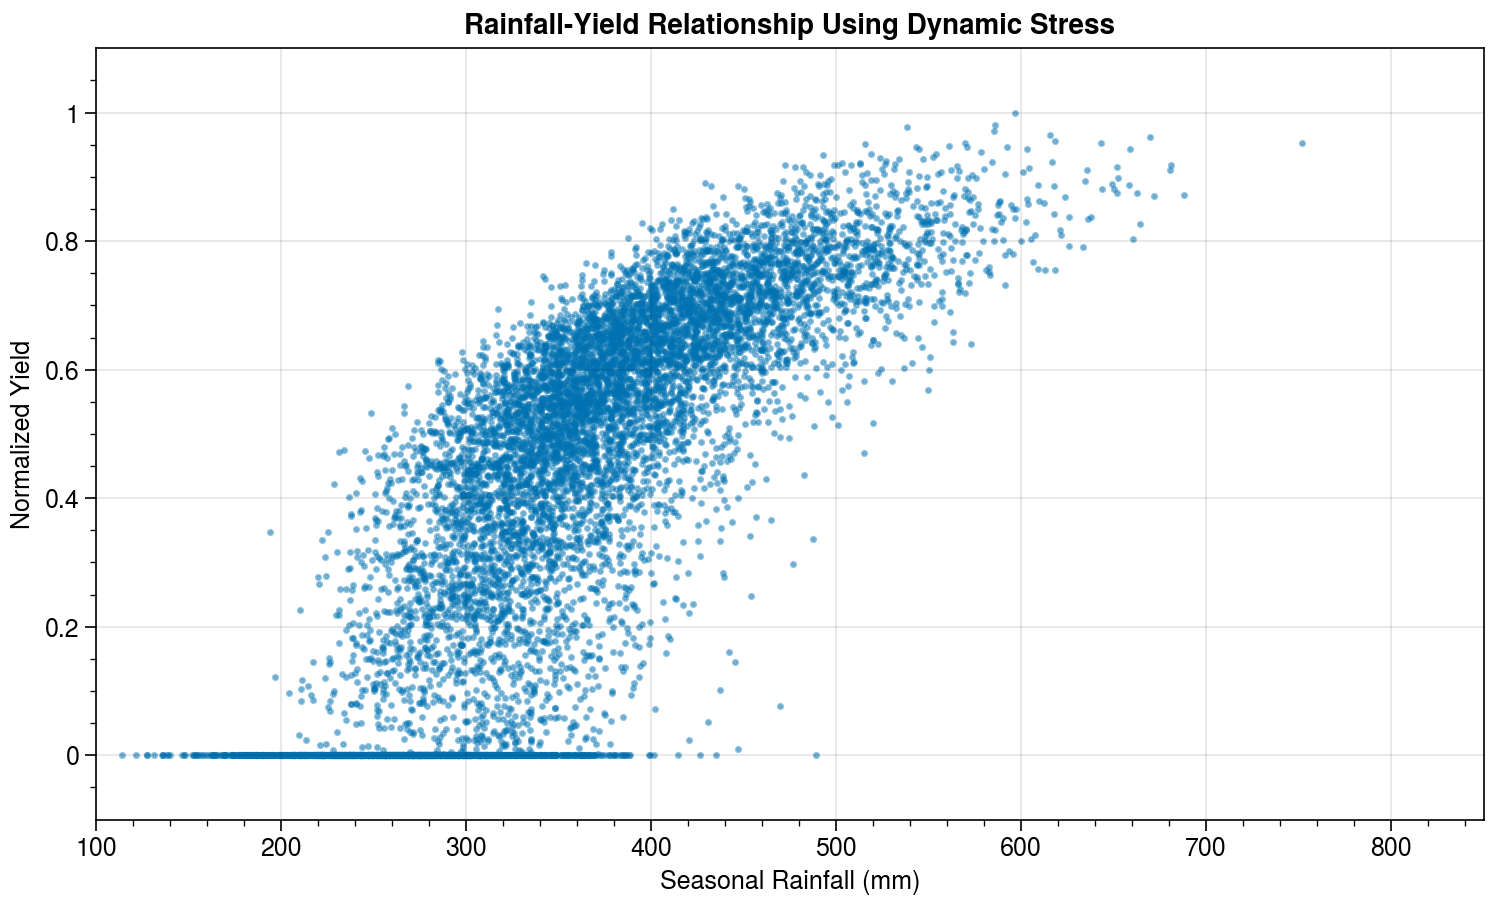

In [24]:
# Dynamic Stress Yield Rlxn

def fig3(df=None):
    # We'll be using these variables a lot
    x = df.RF
    y = df.Yield

    # Scatter plot of raw data
    max(df.Yield)

    df['Yield_norm'] = df.Yield/max(df.Yield)

    f, axs = plot.subplots(journal='agu2') #, tight=False
    axs.format(
        abc=False, abcloc='ul', suptitle='Rainfall-Yield Relationship Using Dynamic Stress')
    
    
    plt.scatter(df.RF, df.Yield_norm, alpha=0.4, size=2.5) # , color='black'
    plt.ylim(-.10,1.10)
    plt.xlim(100,850)
    #plt.title('Rainfall-Yield Relationship Using Dynamic Stress')
    plt.ylabel('Normalized Yield') # Yield normalized by max. yield
    plt.xlabel('Seasonal Rainfall (mm)')
    plt.savefig('../output/6-results/dynstress2.png',format='png')
    # New fit
    #residuals = plot_newfit(df.RF, df.Yield, 'Seasonal Rainfall (mm)', 'Yield (kg/ha)')
    
    #power_law_fit(x,y,'Seasonal Rainfall (mm)', 'Yield (kg/ha)', 'Power law fit')
    # confidence intervals around line?
    
fig3(df=df)

## Step 3. Export then import simulations for varieties <a id='import2'></a>

In [ ]:
# Started off with this but doesn't have evolved calc yields. Need to combine what's below with what's above.

# This timed out. 
def run2():

    # Now I have to re-run the simulations using the max yields from this relationship
    varieties = np.arange(75,180,5)
    len(varieties)

    result = []

    for i in varieties:
        # note: bumping up to 200 sims per cultivar type takes several minutes to run
        # whereas 100 sims where varieties = np.arange(70,200,5) takes less than a minute.
        data, rf, lgp, avg_s, output, start, end, crop, station, texture, pd_sim, n_sim, burn_in = run(n_sim = 500, station = 'OL JOGI FARM', texture = 'clay loam', lgp=i, pd_sim=60)
        df = pd.DataFrame.from_records(data, columns =['AvgStress','DynamicStress','Yield'])
        df['RF'] = rf
        df['Cultivar'] = i
        result.append(df)
        
    return result

result = run2()
result = pd.concat(result)

# Add categorical values for early, medium and late maturing
# There is probably a way more efficient way to do this
def category(x):
    if x < 110:
        return "Early (< 105 d)"
    if 110 <= x <= 140:
        return "Medium (110 - 140 d)"
    else:
        return "Late (145 + d)"

for row in result.Cultivar:
    result['Category'] = result.Cultivar.apply(lambda x: category(x))

result.Category.value_counts()

In [ ]:
result.to_csv('../output/result08302020.csv',sep=',')

### LGP impacts on yield <a id='lgp'></a>

In [ ]:
def plot_lin_regression(x_var = None, y_var = None, x_str = None, y_str = None, data = None, 
                            ann_x = 101, ann_y = 4500, 
                            x_lab = 'X label here', y_lab = 'Y label here', title = 'Title here', positive = False):
        """ Computes linear regression between independent and dependent variable. 
        Usage: plot_lin_regression(x_var, y_var, x_lab, y_lab, title)
            ann_x = where on x-axis annotation should be placed
            ann_y = where on y-axis annotation should be placed
            Returns: R_squared, m, b
        """
        # Define variables
        X, y = x_var, y_var

        # Linear regression
        denominator = X.dot(X) - X.mean() * X.sum()
        m = ( X.dot(y) - y.mean() * X.sum() ) / denominator
        b = (y.mean() * X.dot(X) - X.mean() * X.dot(y) ) / denominator

        y_pred = m*X + b

        # uncomment for white figure
        col = 'black'
        #col = 'white'
        
        
        plt.figure(figsize=(5,4))

        g = sns.lmplot(x_str, y_str, data, ci=95, height=4, scatter_kws={'color':col,'alpha':0.6}) # ,, line_kws={'color': 'black'}

        # Calculate residuals
        res = y - y_pred
        tot = y - y.mean()

        R_squared = 1 - res.dot(res) / tot.dot(tot)
        print(R_squared)
        print('m',m)
        print('b',b)

        if positive == True:
            textstr = '\n'.join((
                r'$ y = %.2f$x' % (m, )+'+$  %0.1f$' % (b, ),
                r'$r^2 = %.2f$' % (R_squared, ))) 
        else:
            textstr = '\n'.join((
            r'$ y = %.2f$x' % (m, )+'$  %.1f$' % (b, ),
            r'$r^2 = %.2f$' % (R_squared, )))

        props = dict(boxstyle='square', facecolor='white', alpha=0.5, lw = 1.5) # , ec="b"

        # place a text box in upper left in axes coords
        plt.text(ann_x, ann_y, textstr, fontsize=10, #transform=ax.transAxes, 
                verticalalignment='top', bbox=props)

        plt.xlabel(x_lab)
        plt.ylabel(y_lab)
        plt.ylim(1,5.2)
        plt.title(title, fontweight="bold")

        return R_squared, m, b
    
def fig4():
    # verified using Kenya Seed Co. - https://web.archive.org/web/20190819125927/http://kenyaseed.com/gallery/maize/
    verified_hybrid_data = pd.read_csv('../data/Yields/hybrid_yields_verified.csv')
    verified_hybrid_data


    # convert to metric tons
    verified_hybrid_data['yield_metric_tons'] = verified_hybrid_data.verified_yield_kg_acre/1000
    verified_hybrid_data
    

    p, m, b = plot_lin_regression(verified_hybrid_data.verified_days_to_maturity, verified_hybrid_data.yield_metric_tons, 
                                  'verified_days_to_maturity', 'yield_metric_tons', verified_hybrid_data, 
                                  85, 5, 'Days to Maturity (days)', 'Potential Yield (tons/ha)', 
                                  'Kenya Seed Co. Potential Yields by Maize Variety')
    
fig4()
plt.savefig('../output/6-results/ksc.pdf',format='pdf')
plt.savefig('../output/6-results/ksc.png',format='png')

### Summary statistics

In [ ]:
# Note to self, this is for getting yields in G3S talk.
x = [crop.calc_dstress(s=df.s, stress=df.stress) for df in output]
print(x[847])
print(output[847][start:end]['R'].sum())

In [ ]:
# want to have table average yield, average rainfall

df = pd.DataFrame(x)
print(df[2].describe())
print(df[2].median())

s_min = []

# rainfall statistics
for i in no_sims:
    #print(output[i][start:end]['s'].min())
    _s_min = output[i][start:end]['R'].sum()
    s_min.append(_s_min)
result = pd.DataFrame({'s_min':s_min})
result.s_min.median()

In [ ]:
# need to output the 10,000 simulations into one dataframe (?) for export
# But then also need to truncate just to start and end for each sim.
# Should be able to do that using a for loop.
#pd.concat(output)
#plt.rcParams.keys()

Notes: How to bound the kde fit on static water stress to zero?
* [DataCamp](https://www.datacamp.com/community/tutorials/probability-distributions-python) article talks about distributions and exponential one still has curve that overflows to zero.
* [Stackoverflow](https://stackoverflow.com/questions/21809876/lower-bound-to-kernel-density-estimation-with-seaborn-for-matplotlib-in-python) says only option is to cut the axis limits to zero. Also [here](https://stackoverflow.com/questions/21809876/lower-bound-to-kernel-density-estimation-with-seaborn-for-matplotlib-in-python). Explanation for why you can get negative values from a positive density kernel density estimation, [stackexchange](https://stats.stackexchange.com/questions/109549/negative-density-for-non-negative-variables).